Muqtadir Ahmed (260987724)

Esteban Levesque (260955869)

#Dashcam Analyzer Project for ECSE-415


## 1. Introduction
Given two dash cam footage, the given task is to detect the number of parked cars, moving cars and pedestrians passed. The two dashcam videos provided are on the McGill street and St-Catherine street. Using multiple computer vision techniques and libraries, such as optical flow, YoloV8, ByteTrack, etc, it was possible to find an accurate prediction of the number of passed parked, moving cars and pedestrians in the given footage.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
path= "/content/drive/MyDrive/ECSE415/"
import cv2
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
# To confirm that GPU is being used
!nvidia-smi

Mon Dec  4 22:06:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Software Packages

### Install YOLOv8


YoloV8 is the most advanced version of the yolo software package used for object detection. Its higher accuracy compared to the previous versions makes it more reliable and easy to use for tracking. In the project, YoloV8 is used to detect and track (with the help of ByteTrack) bikes, people and cars.

In [4]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.1/78.2 GB disk)


### Install ByteTrack

ByteTrack is a software package used to track objects in a video. It allocates IDs to objects detected and tracks them throughout the video. We use it to keep track of the pedestrians, cars and bicycles and prevent objects from being counted multiple times. The update(output_results, img_info, img_size) routine is used to track the objects using the ByteTrack library.

In [5]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

### Install Roboflow Supervision

Supervision a software package used to read videos frame by frame and draw bounding boxes and labels for each detected object and write text on the screen. In our project, this library allows for looping through the video frame by frame to draw the bounding boxes and labels around the detected cars, people and bikes using the routine BoundingBoxAnnotator(). To write text on the screen to display the number of passed objects the LabelAnnotator(text_position) routine is used. Once the video is done being annotated, it is then saved at the specified path location using the VideoSink() routine.

In [7]:
!pip install supervision==0.16.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.16.0


In [8]:
import supervision as sv
from supervision import Detections
from supervision import get_video_frames_generator
from supervision import VideoSink
from supervision.draw.color import ColorPalette
from supervision import Point
from supervision import VideoInfo
from supervision import BoundingBoxAnnotator, LabelAnnotator
from supervision import MaskAnnotator
from supervision.utils.notebook import plot_image
from supervision.draw.utils import draw_text
from supervision.draw.color import Color

### Load pre-trained YOLOv8 model

In [9]:
# settings
MODEL = "yolov8x.pt"

In [10]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [11]:
# dict mapping class_id to class_name
CLASS_NAMES_DICT = model.model.names

## Implementation and Approach
In hopes of achieving the goal, the plan is to detect objects such as cars,  people and bicycles (to exclude bicyclists as pedestrians), track cars and people, count objects that are passed, differentiate between moving and parked cars and differentiate between bicyclists and pedestrians.

1. Detecting Objects

 It was necessary to detect cars and people since the requirements consist of counting those objects. To detect objects, a library called YoloV8 is used. It allows detection of all cars and people for each frame in the video and returns the data for the objects’ bounding box coordinates and confidence levels. With the aid of the library called Supervision made by Roboflow, it was possible to draw the bounding boxes around the detected objects using the information returned by the model. Cars and people were detected at every frame of the video in order to observe the results.

2. Tracking Objects

 Tracking is necessary in order to avoid counting the same object multiple times as the video plays. ByteTrack is used in order to track the detecting objects and provide an ID from them. The ID of the passed object can then be stored in a set in order to keep count. A set is used in this case since it only stores unique values and it allows for constant time searching.

3. Counting Passed Objects

 In order to count the passed objects, it is important to know what defines an object being passed. The assumption made for an object to be considered passed is when the object’s bounding box intersects with either the bottom right or the bottom left side of the screen. This is because when an object is about to be passed either on the left side or right side relative to the dashcam in the real world, it is as if it is going through the bottom left or bottom right side of the screen in the video. Using this assumption, the ID of the object was saved in the respective set only when the object’s bounding box edge intersected with either the left or right side of the screen.

4. Differentiate Between Parked Cars and Moving Cars

 To count moving cars and parked cars separately, it is important to find a way to distinguish moving cars from parked cars. The Lucas-Kanade method of optical flow is used to distinguish between a stationary and a moving object. The assumption made is that parked cars will have similar motion to the stationary background, whereas moving cars will have either much higher or lower motion depending on if the car is going the opposite way from the dashcam or the same way at a similar speed. The methodology used is to first find the motion vector at every 100 pixels in the video. If too many motion vectors were used, it would reduce the performance speed of the program, therefore a design idea was to minimize the number of motion vectors used without heavily affecting the accuracy. A motion vector every 100 pixels showed to give accurate results while remaining time efficient. Motion vectors are then grouped into regions on the screen such that it either detects the motion of passed cars or the stationary building, trees, etc in the background. The average magnitude of the motion vectors are then measured in the regions of interest at every frame. If the average motion magnitude of a passing car is higher or lower than the average motion magnitude of the background, it means that the car is moving either backwards or forwards at a similar speed relative to the dashcam, thus the detected car is classified as a moving car and if the average motion magnitude of the passing car is similar to the background’s average motion magnitude, the car is classified as a parked car.

5. Differentiate Between Bicyclists and Pedestrians

 To distinguish between bikers and pedestrians, it's essential to introduce an additional criterion to prevent wrong detections of pedestrians. The assumption made to detect a bicyclist is that once a detected person and a detected bike passes the dashcam at nearly the same bounding box coordinates or in other words, if the bounding boxes of the two objects intersect, it is considered that the person is a bicyclist. Upon detecting a person and bike being passed, the bounding box coordinates of the two objects are compared to determine if they are intersecting. If the bounding boxes intersect, the person is considered a bicyclist and not included in the count for pedestrians, if not, the person is classified as a pedestrian.

### Predict and annotate whole video

**Tracking utils**

Helper functions to manually match the bounding boxes coming from our model with those created by the tracker.

In [12]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

The detect() function contains the algorithm to detect and count passed moving cars, parked cars and pedestrians. It takes the source path of the video, the target path where the final video will be stored and a motion threshold to determine if the car is moving. The motion threshold is the difference between the average magnitude of motion of the moving objects substracted by the average magnitude of motion of stationary objects


In [13]:
from tqdm.notebook import tqdm

# this function will detect and count moving cars, parked cars and pedestrians
def detect(source_path, target_path, motion_thresh):
  carSet = set()
  personSet = set()
  movingCarSet = set()
  bikerSet = set()
  # create BYTETracker instance
  byte_tracker = BYTETracker(BYTETrackerArgs())
  # create VideoInfo instance
  video_info = VideoInfo.from_video_path(source_path)
  # create frame generator
  generator = get_video_frames_generator(source_path)

  box_annotator = BoundingBoxAnnotator()
  label_annotator = LabelAnnotator(text_position=sv.Position.TOP_LEFT)
  lk_params = dict( winSize = (50,50),
                    maxLevel = 4,
                    minEigThreshold = 0.001,#0.001,
                    criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 0.1),
                    )
  k = 0

  # open target video file
  with VideoSink(target_path, video_info) as sink:
      # loop over video frames
      for frame in tqdm(generator, total=video_info.total_frames):
          # model prediction on single frame and conversion to supervision Detections
          results = model(frame)
          classes = results[0].boxes.cls.cpu().numpy().astype(int)
          xyxy=results[0].boxes.xyxy.cpu().numpy()
          confidence=results[0].boxes.conf.cpu().numpy()

          # Store the detected classes and their respective confidences and bounding box coordinates
          myClasses = []
          myConfidence = []
          myxyxy = []

          for i, val in enumerate(classes):
            # If a car is detected and it's confidence is above 75%, store it.
            if val == 2 and confidence[i] > 0.75:
              myClasses.append(val)
              myConfidence.append(confidence[i])
              myxyxy.append(xyxy[i])

            # Else if a bike is detected and it's confidence is above 50%, store it.
            # We want to detect bikes to avoid counting bikers as pedestrians
            elif val == 1 and confidence[i] > 0.5:
              myClasses.append(val)
              myConfidence.append(confidence[i])
              myxyxy.append(xyxy[i])

            # Else if a person is detected and it's confidence is above 30%, store it.
            elif val == 0 and confidence[i] > 0.3:
              myClasses.append(val)
              myConfidence.append(confidence[i])
              myxyxy.append(xyxy[i])

          # Save the bounding box coordinates, confidences and class ids in the Detection object
          detections = Detections(
              xyxy=np.array(myxyxy),
              confidence=np.array(myConfidence),
              class_id=np.array(myClasses)
          )

          # tracking detections
          tracks = byte_tracker.update(
              output_results=detections2boxes(detections=detections),
              img_info=frame.shape,
              img_size=frame.shape
          )

          # Match the detections with tracks
          tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)

          # Save the tracker ids corresponding to each detected objects in the Detections class
          detections.tracker_id = np.array(tracker_id)

          # indices of the bounding box that touch the left and right sides of the screen
          # this is the trick I used to determine if the object is being passed by the dashcam
          leftPassIndices = np.where(detections.xyxy[:, 0] < 5)[0]  # Object passing from left side
          rightPassIndices = np.where(detections.xyxy[:, 2] > 2555)[0] # Object passing from right side
          passIndices = np.hstack((leftPassIndices, rightPassIndices))

          # Store the tracker and class ids of the objects being passed
          pass_ids = detections.tracker_id[passIndices]
          pass_classes = detections.class_id[passIndices]

          # Turn the tracker id list elements into strings in order to display the label above bounding box
          t_id = []
          for i, val in enumerate(detections.tracker_id):
            t_id.append(str(tracker_id[i]))

          # Measuring the optical flow
          # The optical flow will allow us to distinguish between moving vs parked cars
          # Moving cars will have a larger motion vector compared to parked cars or non moving objects (such as the building next to the cars)
          img2_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

          # The index k allows us to only compute the optical flow starting from the 2nd frame
          # Since we need 2 frames to measure the optical flow
          if k > 0:
            # Get the 2d space where the motions vectors will be
            x = np.arange(0, img1_gray.shape[1],100)
            y = np.arange(0, img1_gray.shape[0],100)
            xv, yv = np.meshgrid(x, y)
            p0 = np.concatenate([xv.reshape(-1,1,1), yv.reshape(-1,1,1)],2).astype(np.float32)
            # compute optic flow
            p1, st, _ = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)

            # The first and second points from 2 frames
            # Good points will be found later when calculating the magnitudes of the motion vectors
            good_new = p1.reshape(-1, 2)
            good_old = p0.reshape(-1, 2)

            # create some random colors
            color = np.random.randint(0, 255, (good_new.shape[0], 3))

            #Find magnitude of the direction vector
            diff_x = good_new[:, 0] - good_old[:, 0]
            diff_y = good_new[:, 1] - good_old[:, 1]

            # Calculate the squared differences
            squared_diff = diff_x**2 + diff_y**2

            # Calculate the magnitude using sqrt
            magnitude = np.sqrt(squared_diff)

            # Set the magnitude value to 0 when the points are bad points
            magnitude = np.where(st == 1, np.floor(magnitude).astype(int).reshape(-1, 1), 0)

            # Average flow magnitude for each region
            # Top left and top right takes the average magnitude in the area where non moving background is seen (either building, trees, etc)
            # Bot left and bot right takes the average magnitude in the area where cars pass by.
            topleft = np.mean(magnitude.reshape(15, 26)[ 3: 7, :6]).astype(int)
            botleft = np.mean(magnitude.reshape(15, 26)[ 10: 13 , :6]).astype(int)
            topright = np.mean(magnitude.reshape(15, 26)[ 3: 7 , 18:]).astype(int)
            botright = np.mean(magnitude.reshape(15, 26)[ 10: 13 , 18:]).astype(int)

            # create a mask image for drawing purposes
            frame = frame.copy()
            # draw red lines to display the motion in the video
            for i, (new, old) in enumerate(zip(p1[st==1], p0[st==1])):
              if (300 <= old[1] < 700 or 1000 <= old[1] < 1300) and (old[0] < 600 or old[0] > 1800):
                a, b = new.ravel()
                c, d = old.ravel()
                a = a.astype(int)
                b = b.astype(int)
                c = c.astype(int)
                d = d.astype(int)
                frame = cv2.arrowedLine(frame, (c,d), (a,b), (0, 0, 204), 2)
            # For testing motion magnitudes
            # frame = cv2.putText(frame, f"{topleft}, {botleft}, {topright}, {botright}", (0,360), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 0), 2, cv2.LINE_AA)

            # Logic for moving car detection, parked car detection, pedestrian detection
            # Loop through the list of objects being passed
            # Each detected passing object (parked car, moving car, bikers, pedestrians are stored in their own set)
            for i, c in enumerate(pass_classes):
              # If the tracker has a None id we don't consider the object
              if pass_ids[i] != None:

                # If a person is being passed
                if c == 0:
                  # Check if any bikes are passed at the same time
                  bike_indices = np.where(pass_classes == 1)[0]

                  # If there a single or many bikes being passed, loop through them
                  for b in bike_indices:

                    # Check if the x coordinates of the top left corners of the bounding boxes (to detect bikers passing from left side) of the bike and person are nearly in the same location
                    # If so, the person is considered a biker and not a pedestrian.
                    if abs(detections.xyxy[passIndices[b]][0] - detections.xyxy[passIndices[i]][0]) < 1: # biker passing on left
                      bikerSet.add(pass_ids[i])

                    # Check if the x coordinates of the bot right corners of the bounding boxes (to detect bikers passing from right side) of the bike and person are nearly in the same location
                    # If so, the person is considered a biker and not a pedestrian.
                    elif abs(detections.xyxy[passIndices[b]][2] - detections.xyxy[passIndices[i]][2]) < 1: # biker passing on right
                      bikerSet.add(pass_ids[i])

                  # If the person is not a biker, it is considered a pedestrian and stored in the personSet.
                  if pass_ids[i] not in bikerSet:
                    personSet.add(pass_ids[i])

                # If a passing car is detected
                elif c == 2: # car

                  # If the average motion vector magnitudes for the passing cars is higher by a threshold than the background,
                  # the car is considered to be moving. Save moving cars in movingCarSet
                  if (botleft - topleft) >= motion_thresh or (topleft - botleft) > 14 and botleft < 2: # car passed by left side and moving car
                    movingCarSet.add(pass_ids[i])
                    if pass_ids[i] in carSet:
                      carSet.remove(pass_ids[i])
                  elif (botright - topright) >= motion_thresh or (topright - botright) > 14 and botright < 2: # car passed by right side and moving car
                    movingCarSet.add(pass_ids[i])
                    if pass_ids[i] in carSet:
                      carSet.remove(pass_ids[i])

                  # If the car isn't moving, it is considered a parked car. Parked car saved in carSet
                  else:
                    if pass_ids[i] not in movingCarSet:
                      carSet.add(pass_ids[i])
            # Draw the statistics of pedestrians passed, parked cars passed and moving cars passed
            frame = draw_text(frame, f"Pedestrian: {len(personSet)}", Point(250, 100), Color.black(), 2, 4, background_color = Color.white())
            frame = draw_text(frame, f"Parked Cars: {len(carSet)}", Point(280, 175), Color.black(), 2, 4, background_color = Color.white())
            frame = draw_text(frame, f"Moving Cars: {len(movingCarSet)}", Point(280, 250), Color.black(), 2, 4, background_color = Color.white())

          # Prev frame = current frame
          img1_gray = img2_gray
          k += 1

          # Add the tracking id label on detected objects
          frame = label_annotator.annotate(frame, detections, t_id)

          # Draw bounding boxes
          frame = box_annotator.annotate(scene=frame, detections=detections)
          sink.write_frame(frame)

Call the detect() function on the McGill video to get the output video

In [14]:
SOURCE_VIDEO_PATH = f"{path}mcgill_drive.mp4"
TARGET_VIDEO_PATH = f"{path}mcgill_detection.mp4"

# Takes around 3 minutes to run this code.
detect(SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, 18)

  0%|          | 0/1071 [00:00<?, ?it/s]


0: 384x640 2 persons, 5 cars, 1 truck, 239.6ms
Speed: 3.2ms preprocess, 239.6ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 truck, 45.7ms
Speed: 3.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 1 truck, 45.8ms
Speed: 3.3ms preprocess, 45.8ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 48.2ms
Speed: 3.2ms preprocess, 48.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 48.1ms
Speed: 3.1ms preprocess, 48.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 1 truck, 1 traffic light, 45.8ms
Speed: 3.0ms preprocess, 45.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 1 truck, 1 traffic light, 46.3ms
Speed: 5.1ms preprocess, 46.3ms inference, 2.1ms post

Call the detect() function on the St-Catherine video to get the output video

In [15]:
SOURCE_VIDEO_PATH = f"{path}st-catherines_drive.mp4"
TARGET_VIDEO_PATH = f"{path}catherine_detection.mp4"
# Takes about 4-5 minutes to run
detect(SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, 55)

  0%|          | 0/1477 [00:00<?, ?it/s]


0: 384x640 5 persons, 2 bicycles, 7 cars, 1 bus, 1 truck, 54.7ms
Speed: 3.4ms preprocess, 54.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 bicycles, 7 cars, 1 bus, 1 truck, 54.8ms
Speed: 3.2ms preprocess, 54.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 bicycles, 7 cars, 1 truck, 54.9ms
Speed: 3.6ms preprocess, 54.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 bicycles, 7 cars, 1 truck, 63.1ms
Speed: 3.3ms preprocess, 63.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 bicycles, 7 cars, 1 truck, 63.3ms
Speed: 3.7ms preprocess, 63.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 bicycles, 7 cars, 1 truck, 63.1ms
Speed: 3.7ms preprocess, 63.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 bicycles, 7 cars, 1 bus, 

## Output and Results

After running the following codes the final video will be saved in your target path.
Since displaying the large video using google colab is a little difficult I will provide an youtube video with the final result.

### Performance and Problems

In terms of performance, the program has its strengths and its flaws for each video which will be discussed in the following sentences. There were a couple of main sources of inaccuracy, such as an object being blocked by another object, counting the reflection of an object on a window and the color of the object blending in with the background.

**Video Live Output Description**

In the following videos, the number of moving cars, parked cars and pedestrians passed are counted and shown live on the top left corner of the video. People, cars and bicycles have a bounding box around them with an ID as a label to visualize the tracking of those objects. The red motion vectors are displayed ONLY in the regions of interest (the regions where the average magnitude of the motion vectors are calculated).

**McGill Drive Output Video**

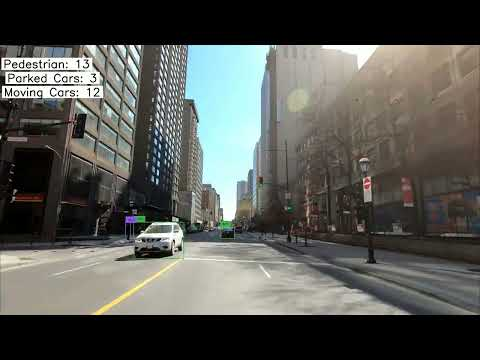

In [16]:
from IPython.display import YouTubeVideo
YouTubeVideo('HI_XG6K85M4')

For the McGill drive video, the overall accuracy was above 88% and there were a couple of factors that caused the accuracy to decrease. The program was not able to detect cars that were blocked by an object, such as a bus or another car, which prevented the program from counting the car. Same problem occurred for pedestrians as they could not be counted when blocked by an object. Furthermore, inaccuracies due to the model detecting the car’s reflection on a window caused the program to overcount a parked or moving car. As for the last main source of inaccuracy, a couple of the pedestrians were wearing the same colored clothes as the background which made it harder for the model to detect them. To somewhat tackle this problem, the confidence levels were reduced to allow a higher chance at detecting a pedestrian. Other than these sources of inaccuracies, the program was able to accurately detect moving cars, parked cars and pedestrians in the McGill video.

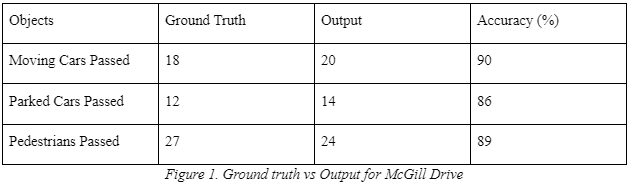

**St-Catherine Drive Output Video**

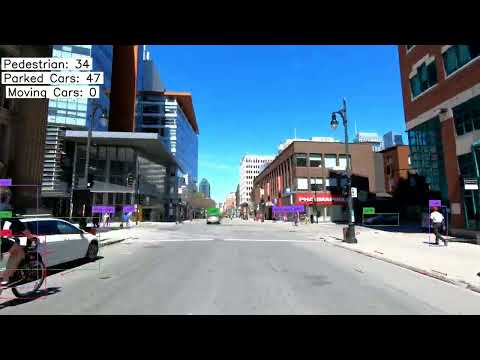

In [17]:
YouTubeVideo('fau-U6aSKbE')

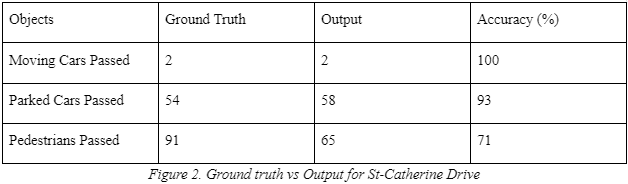

For the St-Catherine video the overall accuracy is 88% and the main source of inaccuracy was the pedestrians being blocked by nearby objects such as cars or buses. The pedestrians were most of the time behind an object and the model could not detect them. This prevented many pedestrians from being counted. Furthermore, there were two moving cars in this video, but the cars were moving in the same direction as the dashcam at a similar speed. The program was able to count the two forward moving cars accurately as moving cars. Other than these sources of inaccuracies, the program was able to accurately detect moving cars, parked cars and pedestrians in the St-Catherine video.

## Conclusion and References


In summary, in this assignment, a program was created to count the number of passed moving cars, parked cars and pedestrians for two dashcam footage. This challenge was tackled with the help of multiple software libraries such as YoloV8, ByteTrack, Supervision by Roboflow and OpenCv for Lucas-Kanade optical flow method. The output of the program had an accuracy of above 88% which can be considered to be highly accurate.

References:
- Tutorial 11 (for motion detection)
- https://docs.ultralytics.com/modes/track/
- https://blog.roboflow.com/yolov8-tracking-and-counting/
- https://supervision.roboflow.com/